# Постановка задачи

К вам попали результаты A/A/B-тестирования от одного известного маркетплейса.

* sample_a, sample_c — АА-группы,  
* sample_b — отдельная группа.

В каждом датасете есть три типа действий пользователей:  
* 0 — клик,  
* 1 — просмотр,  
* 2 — покупка

(пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

* ctr (отношение кликов к просмотрам товаров);  
* purchase rate (отношение покупок к просмотрам товаров);  
* gmv (оборот, сумма произведений количества покупок на стоимость покупки),  
где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

Данные уже почищены по сессиям, вы можете использовать их в агрегированном виде. Ваша задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

Тест Шапиро-Уилка проведите на alpha = 0.01.

# Загрузка и проверка данных

In [125]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import warnings

from statsmodels.stats.weightstats import ztest
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

warnings.filterwarnings('ignore')

Загружаем данные.

In [2]:
sample_a = pd.read_csv('sample_a.csv')
sample_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [3]:
sample_b = pd.read_csv('sample_b.csv')
sample_b.head()

,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1


In [4]:
sample_c = pd.read_csv('sample_c.csv')
sample_c.head()

,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2


In [5]:
item_prices = pd.read_csv('item_prices.csv')
item_prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


Проверим нет ли на один и тот же товар нескольких цен.

In [6]:
item_prices['item_id'].value_counts()[:5]

,count
item_id,
338,3
8581,3
5258,2
7204,2
8111,2


Есть, и это нормально - в реальной жизни цены на один и тот же товар могут быть разными.  
Оставим только медианные цены.

In [7]:
median_prices = item_prices.groupby(
    'item_id',
    as_index = False
)['item_price'].median()

Проверяем:

In [8]:
display(item_prices[item_prices['item_id'] == 338])
display(median_prices[median_prices['item_id'] == 338])

,item_id,item_price
0,338,1501
797,338,1151
977,338,1047


,item_id,item_price
33,338,1151.0


In [9]:
display(item_prices[item_prices['item_id'] == 5258])
display(median_prices[median_prices['item_id'] == 5258])

,item_id,item_price
46,5258,586
772,5258,984


,item_id,item_price
515,5258,785.0


Проведём проверку, что нет ситуаций, когда происходит покупка/клик без действия просмотра.

In [10]:
# проверяем a образцы
sample_a_views = sample_a[sample_a['action_id'] == 1]    # просмотры
sample_a_success = sample_a[sample_a['action_id'] != 1]  # покупка/клик

# присоединяем к таблице покупка/клик информацию о просмотрах, если есть
merged_sample_a = pd.merge(
    sample_a_success,
    sample_a_views,
    how = 'left',
    on = ['user_id', 'item_id']
)

# проверяем количество пропусков
merged_sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237782 entries, 0 to 237781
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      237782 non-null  int64
 1   item_id      237782 non-null  int64
 2   action_id_x  237782 non-null  int64
 3   action_id_y  237782 non-null  int64
dtypes: int64(4)
memory usage: 7.3 MB


In [11]:
# проверяем b образцы
sample_b_views = sample_b[sample_b['action_id'] == 1]    # просмотры
sample_b_success = sample_b[sample_b['action_id'] != 1]  # покупка/клик

# присоединяем к таблице покупка/клик информацию о просмотрах, если есть
merged_sample_b = pd.merge(
    sample_b_success,
    sample_b_views,
    how = 'left',
    on = ['user_id', 'item_id']
)

# проверяем количество пропусков
merged_sample_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247297 entries, 0 to 247296
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      247297 non-null  int64
 1   item_id      247297 non-null  int64
 2   action_id_x  247297 non-null  int64
 3   action_id_y  247297 non-null  int64
dtypes: int64(4)
memory usage: 7.5 MB


In [12]:
# проверяем c образцы
sample_c_views = sample_c[sample_c['action_id'] == 1]    # просмотры
sample_c_success = sample_c[sample_c['action_id'] != 1]  # покупка/клик

# присоединяем к таблице покупка/клик информацию о просмотрах, если есть
merged_sample_c = pd.merge(
    sample_c_success,
    sample_c_views,
    how = 'left',
    on = ['user_id', 'item_id']
)

# проверяем количество пропусков
merged_sample_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256289 entries, 0 to 256288
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   user_id      256289 non-null  int64
 1   item_id      256289 non-null  int64
 2   action_id_x  256289 non-null  int64
 3   action_id_y  256289 non-null  int64
dtypes: int64(4)
memory usage: 7.8 MB


Ситуаций, когда происходит покупка/клик без действия просмотра не выявлено (нас интересовали пропуски в колонке action_id_y).

Проверяем данные на наличие дублей:

In [13]:
print('Количество дублей в образцах a:', sample_a.duplicated().sum())
print('Количество дублей в образцах b:', sample_b.duplicated().sum())
print('Количество дублей в образцах c:', sample_c.duplicated().sum())

Количество дублей в образцах a: 0
Количество дублей в образцах b: 0
Количество дублей в образцах c: 0


# Рассчёт метрик

In [62]:
# считаем количество действий каждого типа в каждом датасете
action_a = sample_a['action_id'].value_counts().rename('a')
action_b = sample_b['action_id'].value_counts().rename('b')
action_c = sample_c['action_id'].value_counts().rename('c')
pd.concat([action_a, action_b, action_c], axis = 1)

,a,b,c
action_id,,,
1,951130,951141,949221
0,190226,152183,199336
2,47556,95114,56953


In [63]:
# отношение кликов к просмотрам товаров
print('ctr a:', round(action_a.loc[0] / action_a.loc[1], 4))
print('ctr b:', round(action_b.loc[0] / action_b.loc[1], 4))
print('ctr c:', round(action_c.loc[0] / action_c.loc[1], 4))

ctr a: 0.2
ctr b: 0.16
ctr c: 0.21


In [15]:
# отношение покупок к просмотрам товаров
print('purchase rate a:', round(action_a.loc[2] / action_a.loc[1], 4))
print('purchase rate b:', round(action_b.loc[2] / action_b.loc[1], 4))
print('purchase rate c:', round(action_c.loc[2] / action_c.loc[1], 4))

purchase rate a: 0.05
purchase rate b: 0.1
purchase rate c: 0.06


In [39]:
# оборот
sales_a = sample_a[sample_a['action_id'] == 2]
sales_b = sample_b[sample_b['action_id'] == 2]
sales_c = sample_c[sample_c['action_id'] == 2]

# добавляем стоимость позиций
sales_a = pd.merge(sales_a, median_prices, how = 'left', on = 'item_id')
sales_b = pd.merge(sales_b, median_prices, how = 'left', on = 'item_id')
sales_c = pd.merge(sales_c, median_prices, how = 'left', on = 'item_id')

# суммируем продажи
print('gmv a:', round(sales_a['item_price'].sum()))
print('gmv b:', round(sales_b['item_price'].sum()))
print('gmv c:', round(sales_c['item_price'].sum()))

gmv a: 50858316
gmv b: 101642728
gmv c: 60856770


На первый взгляд метрики в АА-группах (a, c) выглядят схожими, в B группе отличаются. В группе B увеличились отношение покупок к просмотрам товаров и оборот, при этом немного упало отношение кликов к просмотрам товаров. Проверим метрики для каждого товара в отдельность. Для этого проведён тест равенства долей для:
* A и C групп по всем метрикам,
* A и B групп по всем метрикам.

# Тест равенства долей для A и C групп
Используем Z-тест потому, что мы имеем дело с распределением Бернулли.  
Оставим только те продукты, у которых есть хотя бы по 30 просмотров.

## Отношение кликов к просмотрам для каждого товара

In [33]:
# подготавливаем отдельный датафрейм с просмотрами и кликам
a_clicks = sample_a[sample_a['action_id'] != 2]
c_clicks = sample_c[sample_c['action_id'] != 2]

# приводим action_id к привычному виду: 0 - просмотр, 1 - клик
a_clicks['action_id'] = a_clicks['action_id'].map({1: 0, 0: 1})
c_clicks['action_id'] = c_clicks['action_id'].map({1: 0, 0: 1})

# сортируем данные, чтобы сначали шли просмотры, а потом клики
a_clicks = a_clicks.sort_values('action_id')
c_clicks = c_clicks.sort_values('action_id')

# удаляем просмотры для каждой пары user_id/item_id если есть клик
a_clicks = a_clicks.drop_duplicates(['user_id', 'item_id'], keep = 'last')
c_clicks = c_clicks.drop_duplicates(['user_id', 'item_id'], keep = 'last')

# возвращаем сотрировку по индексу
a_clicks = a_clicks.sort_index()
c_clicks = c_clicks.sort_index()

# объединяем датафреймы в один с добавлением колонки группы
a_clicks['sample'] = 'a'
c_clicks['sample'] = 'c'
ac_clicks = pd.concat([a_clicks, c_clicks])

# считаем долю кликов для каждого продукта
ac_clicks_ratio = {'item': [], 'ctr_a': [], 'ctr_c': [], 'p_value': []}

for item, group in ac_clicks.groupby('item_id'):
    a = group[group['sample'] == 'a']['action_id'].values
    c = group[group['sample'] == 'c']['action_id'].values

    if len(a) < 30 or len(c) < 30:
        continue

    statistic, p_value = ztest(a, c)
    ac_clicks_ratio['item'].append(item)
    ac_clicks_ratio['ctr_a'].append(np.mean(a))
    ac_clicks_ratio['ctr_c'].append(np.mean(c))
    ac_clicks_ratio['p_value'].append(p_value)

# преобразовываем в датафрейм и смотрим на результат
ac_clicks_ratio = pd.DataFrame(ac_clicks_ratio)
ac_clicks_ratio.sample(10)

,item,ctr_a,ctr_c,p_value
44,462,0.189759,0.208249,0.301712
706,7477,0.200803,0.203424,0.884351
924,9720,0.177711,0.212274,0.051567
703,7422,0.218876,0.204225,0.423817
526,5400,0.213855,0.206237,0.676720
158,1679,0.195980,0.222334,0.148457
745,7782,0.182731,0.222334,0.027834
133,1462,0.198795,0.209256,0.562774
174,1874,0.180723,0.201207,0.245138
496,5035,0.213855,0.182093,0.075337


Теперь посчитаем количество продуктов с p_value < 0.05. Так мы поймём, для скольких продуктов мы бы отвергли нулевую гипотезу без поправок о множественной проверки гипотез.

In [34]:
result = ac_clicks_ratio[ac_clicks_ratio['p_value'] <= 0.05].shape
print('Количество продуктов:', f'{result[0]}/{len(ac_clicks_ratio)}')

Количество продуктов: 87/955


Cравним результаты с поправкой Бонферрони и методом Холма.

In [35]:
result = multipletests(
    ac_clicks_ratio['p_value'],
    alpha = 0.05,
    method = 'bonferroni'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ac_clicks_ratio)}')

Количество продуктов: 1/955


In [36]:
result = multipletests(
    ac_clicks_ratio['p_value'],
    alpha = 0.05,
    method = 'holm'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ac_clicks_ratio)}')

Количество продуктов: 1/955


Множественная проверка гипотез выявила только 1 продукт (при alpha = 0.05), для которого стоит отвергнуть нулевую гипотезу о равенстве отношения кликов к просмотрам товаров для A и C групп. Будем считать, что у нас нет проблемы с разъезжанием сплитов по метрике ctr.

## Отношение покупок к просмотрам для каждого товара

In [113]:
# подготавливаем отдельный датафрейм с просмотрами и покупками
a_purchases = sample_a[sample_a['action_id'] != 0]
c_purchases = sample_c[sample_c['action_id'] != 0]

# приводим action_id к привычному виду: 0 - просмотр, 1 - покупка
a_purchases['action_id'] = a_purchases['action_id'].map({1: 0, 2: 1})
c_purchases['action_id'] = c_purchases['action_id'].map({1: 0, 2: 1})

# сортируем данные, чтобы сначали шли просмотры, а потом покупка
a_purchases = a_purchases.sort_values('action_id')
c_purchases = c_purchases.sort_values('action_id')

# удаляем просмотры для каждой пары user_id/item_id если есть покупка
a_purchases = a_purchases.drop_duplicates(['user_id', 'item_id'], keep = 'last')
c_purchases = c_purchases.drop_duplicates(['user_id', 'item_id'], keep = 'last')

# возвращаем сотрировку по индексу
a_purchases = a_purchases.sort_index()
c_purchases = c_purchases.sort_index()

# объединяем датафреймы в один с добавлением колонки группы
a_purchases['sample'] = 'a'
c_purchases['sample'] = 'c'
ac_purchases = pd.concat([a_purchases, c_purchases])

# считаем долю покупок для каждого продукта
ac_purchases_ratio = {'item': [], 'rate_a': [], 'rate_c': [], 'p_value': []}

for item, group in ac_purchases.groupby('item_id'):
    a = group[group['sample'] == 'a']['action_id'].values
    c = group[group['sample'] == 'c']['action_id'].values

    if len(a) < 30 or len(c) < 30:
        continue

    statistic, p_value = ztest(a, c)
    ac_purchases_ratio['item'].append(item)
    ac_purchases_ratio['rate_a'].append(np.mean(a))
    ac_purchases_ratio['rate_c'].append(np.mean(c))
    ac_purchases_ratio['p_value'].append(p_value)

# преобразовываем в датафрейм и смотрим на результат
ac_purchases_ratio = pd.DataFrame(ac_purchases_ratio)
ac_purchases_ratio.sample(10)

,item,rate_a,rate_c,p_value
429,4359,0.048193,0.060362,0.230940
364,3786,0.057229,0.061368,0.695995
556,5748,0.044177,0.069486,0.014666
467,4780,0.054217,0.070423,0.134794
193,2112,0.043173,0.054326,0.248052
18,179,0.045181,0.054326,0.348294
578,5993,0.043173,0.061368,0.068123
71,692,0.040161,0.052314,0.196769
184,1939,0.049197,0.053320,0.676791
536,5493,0.043173,0.053320,0.290956


Теперь посчитаем количество продуктов с p_value < 0.05. Так мы поймём, для скольких продуктов мы бы отвергли нулевую гипотезу без поправок о множественной проверки гипотез.

In [30]:
result = ac_purchases_ratio[ac_purchases_ratio['p_value'] <= 0.05].shape
print('Количество продуктов:', f'{result[0]}/{len(ac_purchases_ratio)}')

Количество продуктов: 171/955


Cравним результаты с поправкой Бонферрони и методом Холма.

In [38]:
result = multipletests(
    ac_purchases_ratio['p_value'],
    alpha = 0.05,
    method = 'bonferroni'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ac_purchases_ratio)}')

Количество продуктов: 2/955


In [32]:
result = multipletests(
    ac_purchases_ratio['p_value'],
    alpha = 0.05,
    method = 'holm'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ac_purchases_ratio)}')

Количество продуктов: 2/955


Множественная проверка гипотез выявила только 2 продукта (при alpha = 0.05), для которого стоит отвергнуть нулевую гипотезу о равенстве отношения покупок к просмотрам товаров для A и C групп. Будем считать, что у нас нет проблемы с разъезжанием сплитов по метрике purchase rate.

## Отношение оборота к просмотрам для каждого товара

Вообще GMV (Gross Merchandise Value, или валовая стоимость товара) — это совокупная стоимость всех товаров, проданных на площадке за выбранный отрезок времени. Но мы будем делить эту метрику на количество просмотров для более объективной оценки, так как количество просмотров для каждого товара может быть разным.

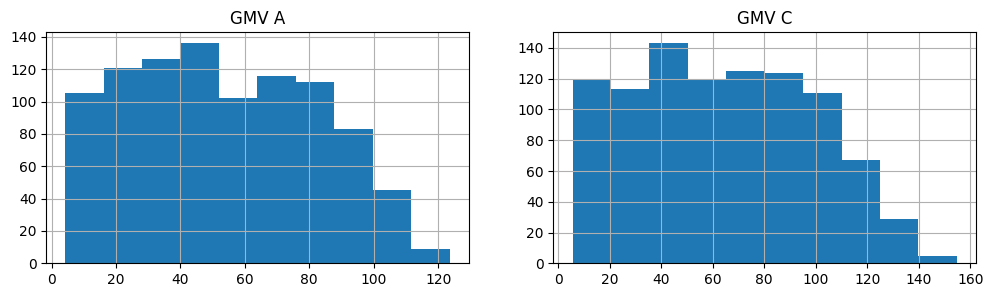

In [128]:
# добавляем объём продаж к нашему датафрейму с просмотрами и покупками
ac_purchases = pd.merge(
    ac_purchases,
    median_prices,
    how = 'left',
    on = 'item_id'
)
ac_purchases['sales'] = ac_purchases['action_id'] * ac_purchases['item_price']

# считаем отношение оборота к просмотрам для каждого продукта
ac_sales_ratio = {'item': [], 'gmv_a': [], 'gmv_c': []}

for item, group in ac_purchases.groupby('item_id'):
    a = group[group['sample'] == 'a']['sales'].values
    c = group[group['sample'] == 'c']['sales'].values
    ac_sales_ratio['item'].append(item)
    ac_sales_ratio['gmv_a'].append(np.mean(a))
    ac_sales_ratio['gmv_c'].append(np.mean(c))

# преобразовываем в датафрейм
ac_sales_ratio = pd.DataFrame(ac_sales_ratio)

# визуализируем данные
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ac_sales_ratio['gmv_a'].hist(ax = axes[0])
axes[0].set_title('GMV A')
ac_sales_ratio['gmv_c'].hist(ax = axes[1])
axes[1].set_title('GMV C');

Распределения данных не похожи на нормальные, но схожи между собой. Однако можно заметить, что правая граница образцов С выше (160), чем образцов А (120), что говорит о том, что и метрика может расходиться. Проверим наши предположения статистическими тестами.

Проверяем данные на нормальность с помощь теста Шапиро-Уилка.

In [129]:
# формируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Распределение отлично от нормального.'

# устанавливаем уровень значимости
alpha = 0.01

for group in ['a', 'c']:
    _, p_value = shapiro(ac_sales_ratio[f'gmv_{group}'])
    print(f'P-value для группы {group}: {p_value}')

    # интерпритация полученного результата
    if p_value > alpha:
        print(H0)
    else:
        print(Ha)
    print()

P-value для группы a: 1.6282126657264485e-13
Распределение отлично от нормального.

P-value для группы c: 3.882358430130329e-13
Распределение отлично от нормального.



Для сравнения признаков распределённых не по нормальному закону подойдёт U-критерий Манна-Уитни.

In [134]:
# формируем нулевую и альтернативную гипотезы
H0 = 'Распределения равны.'
Ha = 'Распределение GMV для образцов А меньше, чем для образцов C.'

# устанавливаем уровень значимости
alpha = 0.05

_, p_value = mannwhitneyu(
    ac_sales_ratio['gmv_a'],
    ac_sales_ratio['gmv_c'],
    alternative = 'less'
)
print(f'P-value: {p_value}')

# интерпритация полученного результата
if p_value > alpha:
    print(H0)
else:
    print(Ha)

P-value: 3.454895623953032e-11
Распределение GMV для образцов А меньше, чем для образцов C.


Контрольные группы A и C расходятся по метрике gmv. Причины этому могут быть разные: различные девайсы, браузеры, источник перехода (например, кто-то перешёл с рекламы, а она тоже бывает разная) и т. д. К сожалению, учесть все эти факторы невозможно почти никогда.

# Тест равенства долей для A и B групп

## Отношение кликов к просмотрам для каждого товара

In [135]:
# подготавливаем отдельный датафрейм с просмотрами и кликам
a_clicks = sample_a[sample_a['action_id'] != 2]
b_clicks = sample_b[sample_b['action_id'] != 2]

# приводим action_id к привычному виду: 0 - просмотр, 1 - клик
a_clicks['action_id'] = a_clicks['action_id'].map({1: 0, 0: 1})
b_clicks['action_id'] = b_clicks['action_id'].map({1: 0, 0: 1})

# сортируем данные, чтобы сначали шли просмотры, а потом клики
a_clicks = a_clicks.sort_values('action_id')
b_clicks = b_clicks.sort_values('action_id')

# удаляем просмотры для каждой пары user_id/item_id если есть клик
a_clicks = a_clicks.drop_duplicates(['user_id', 'item_id'], keep = 'last')
b_clicks = b_clicks.drop_duplicates(['user_id', 'item_id'], keep = 'last')

# возвращаем сотрировку по индексу
a_clicks = a_clicks.sort_index()
b_clicks = b_clicks.sort_index()

# объединяем датафреймы в один с добавлением колонки группы
a_clicks['sample'] = 'a'
b_clicks['sample'] = 'b'
ab_clicks = pd.concat([a_clicks, b_clicks])

# считаем долю кликов для каждого продукта
ab_clicks_ratio = {'item': [], 'ctr_a': [], 'ctr_b': [], 'p_value': []}

for item, group in ab_clicks.groupby('item_id'):
    a = group[group['sample'] == 'a']['action_id'].values
    b = group[group['sample'] == 'b']['action_id'].values

    if len(a) < 30 or len(b) < 30:
        continue

    statistic, p_value = ztest(a, b)
    ab_clicks_ratio['item'].append(item)
    ab_clicks_ratio['ctr_a'].append(np.mean(a))
    ab_clicks_ratio['ctr_b'].append(np.mean(b))
    ab_clicks_ratio['p_value'].append(p_value)

# преобразовываем в датафрейм и смотрим на результат
ab_clicks_ratio = pd.DataFrame(ab_clicks_ratio)
ab_clicks_ratio.sample(10)

,item,ctr_a,ctr_b,p_value
456,4560,0.220884,0.165829,0.001833
575,5962,0.192771,0.164659,0.101464
688,7209,0.189759,0.152610,0.027633
234,2499,0.210843,0.176707,0.053835
146,1593,0.198795,0.152610,0.006691
642,6723,0.205823,0.172691,0.058985
829,8581,0.217871,0.149598,0.000079
727,7641,0.201807,0.147590,0.001408
761,7963,0.205823,0.160643,0.009070
298,3136,0.190763,0.160643,0.077275


Теперь посчитаем количество продуктов с p_value < 0.05. Так мы поймём, для скольких продуктов мы бы отвергли нулевую гипотезу без поправок о множественной проверки гипотез.

In [136]:
result = ab_clicks_ratio[ab_clicks_ratio['p_value'] <= 0.05].shape
print('Количество продуктов:', f'{result[0]}/{len(ab_clicks_ratio)}')

Количество продуктов: 624/955


Cравним результаты с поправкой Бонферрони и методом Холма.

In [137]:
result = multipletests(
    ab_clicks_ratio['p_value'],
    alpha = 0.05,
    method = 'bonferroni'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ab_clicks_ratio)}')

Количество продуктов: 41/955


In [138]:
result = multipletests(
    ab_clicks_ratio['p_value'],
    alpha = 0.05,
    method = 'holm'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ab_clicks_ratio)}')

Количество продуктов: 41/955


Множественная проверка гипотез выявила 41 продукт (при alpha = 0.05), для которого стоит отвергнуть нулевую гипотезу о равенстве отношения кликов к просмотрам товаров для A и B групп. С учётом того, что в среднем значение метрики ctr в группе В ниже, чем в группе А, можно сделать вывод, что алгоритм B снижает отношение кликов к просмотрам товаров.

## Отношение покупок к просмотрам для каждого товара

In [140]:
# подготавливаем отдельный датафрейм с просмотрами и покупками
a_purchases = sample_a[sample_a['action_id'] != 0]
b_purchases = sample_b[sample_b['action_id'] != 0]

# приводим action_id к привычному виду: 0 - просмотр, 1 - покупка
a_purchases['action_id'] = a_purchases['action_id'].map({1: 0, 2: 1})
b_purchases['action_id'] = b_purchases['action_id'].map({1: 0, 2: 1})

# сортируем данные, чтобы сначали шли просмотры, а потом покупка
a_purchases = a_purchases.sort_values('action_id')
b_purchases = b_purchases.sort_values('action_id')

# удаляем просмотры для каждой пары user_id/item_id если есть покупка
a_purchases = a_purchases.drop_duplicates(['user_id', 'item_id'], keep = 'last')
b_purchases = b_purchases.drop_duplicates(['user_id', 'item_id'], keep = 'last')

# возвращаем сотрировку по индексу
a_purchases = a_purchases.sort_index()
b_purchases = b_purchases.sort_index()

# объединяем датафреймы в один с добавлением колонки группы
a_purchases['sample'] = 'a'
b_purchases['sample'] = 'b'
ab_purchases = pd.concat([a_purchases, b_purchases])

# считаем долю покупок для каждого продукта
ab_purchases_ratio = {'item': [], 'rate_a': [], 'rate_b': [], 'p_value': []}

for item, group in ab_purchases.groupby('item_id'):
    a = group[group['sample'] == 'a']['action_id'].values
    b = group[group['sample'] == 'b']['action_id'].values

    if len(a) < 30 or len(b) < 30:
        continue

    statistic, p_value = ztest(a, b)
    ab_purchases_ratio['item'].append(item)
    ab_purchases_ratio['rate_a'].append(np.mean(a))
    ab_purchases_ratio['rate_b'].append(np.mean(b))
    ab_purchases_ratio['p_value'].append(p_value)

# преобразовываем в датафрейм и смотрим на результат
ab_purchases_ratio = pd.DataFrame(ab_purchases_ratio)
ab_purchases_ratio.sample(10)

,item,rate_a,rate_b,p_value
628,6567,0.051205,0.096386,1.092393e-04
421,4282,0.046185,0.097390,8.732800e-06
168,1811,0.046185,0.096386,1.227577e-05
389,3962,0.046185,0.107430,2.413526e-07
97,1062,0.043173,0.102410,3.068356e-07
708,7493,0.052209,0.076305,2.819980e-02
642,6723,0.043173,0.109438,2.010381e-08
291,3073,0.039196,0.098394,1.513253e-07
209,2259,0.049197,0.112450,1.874324e-07
891,9264,0.053213,0.102410,3.892330e-05


Теперь посчитаем количество продуктов с p_value < 0.05. Так мы поймём, для скольких продуктов мы бы отвергли нулевую гипотезу без поправок о множественной проверки гипотез.

In [141]:
result = ab_purchases_ratio[ab_purchases_ratio['p_value'] <= 0.05].shape
print('Количество продуктов:', f'{result[0]}/{len(ab_purchases_ratio)}')

Количество продуктов: 946/955


Cравним результаты с поправкой Бонферрони и методом Холма.

In [142]:
result = multipletests(
    ab_purchases_ratio['p_value'],
    alpha = 0.05,
    method = 'bonferroni'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ab_purchases_ratio)}')

Количество продуктов: 568/955


In [144]:
result = multipletests(
    ab_purchases_ratio['p_value'],
    alpha = 0.05,
    method = 'holm'
)[0].sum()
print('Количество продуктов:', f'{result}/{len(ab_purchases_ratio)}')

Количество продуктов: 665/955


Множественная проверка гипотез выявила 568 (с поправкой Бонферрони) и 665 (методом Холма) продуков (при alpha = 0.05), для которых стоит отвергнуть нулевую гипотезу о равенстве отношения покупок к просмотрам товаров для A и B групп. С учётом того, что в среднем значение метрики purchase rate в группе В выше, чем в группе А, можно сделать вывод, что алгоритм B значительно улучшает отношение покупок к просмотрам товаров.

## Отношение оборота к просмотрам для каждого товара

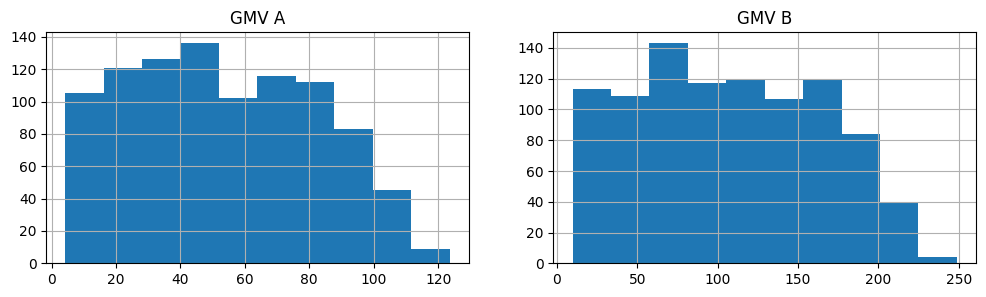

In [147]:
# добавляем объём продаж к нашему датафрейму с просмотрами и покупками
ab_purchases = pd.merge(
    ab_purchases,
    median_prices,
    how = 'left',
    on = 'item_id'
)
ab_purchases['sales'] = ab_purchases['action_id'] * ab_purchases['item_price']

# считаем отношение оборота к просмотрам для каждого продукта
ab_sales_ratio = {'item': [], 'gmv_a': [], 'gmv_b': []}

for item, group in ab_purchases.groupby('item_id'):
    a = group[group['sample'] == 'a']['sales'].values
    b = group[group['sample'] == 'b']['sales'].values
    ab_sales_ratio['item'].append(item)
    ab_sales_ratio['gmv_a'].append(np.mean(a))
    ab_sales_ratio['gmv_b'].append(np.mean(b))

# преобразовываем в датафрейм
ab_sales_ratio = pd.DataFrame(ab_sales_ratio)

# визуализируем данные
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
ab_sales_ratio['gmv_a'].hist(ax = axes[0])
axes[0].set_title('GMV A')
ab_sales_ratio['gmv_b'].hist(ax = axes[1])
axes[1].set_title('GMV B');

Распределения данных не похожи на нормальные, но схожи между собой. Однако можно заметить, что правая граница образцов B выше (250), чем образцов А (120), что говорит о том, что и метрика может расходиться. Проверим наши предположения статистическими тестами.

Проверяем данные на нормальность с помощь теста Шапиро-Уилка.

In [148]:
# формируем нулевую и альтернативную гипотезы
H0 = 'Данные распределены нормально.'
Ha = 'Распределение отлично от нормального.'

# устанавливаем уровень значимости
alpha = 0.01

for group in ['a', 'b']:
    _, p_value = shapiro(ab_sales_ratio[f'gmv_{group}'])
    print(f'P-value для группы {group}: {p_value}')

    # интерпритация полученного результата
    if p_value > alpha:
        print(H0)
    else:
        print(Ha)
    print()

P-value для группы a: 1.6282126657264485e-13
Распределение отлично от нормального.

P-value для группы b: 6.180907394452793e-14
Распределение отлично от нормального.



Для сравнения признаков распределённых не по нормальному закону подойдёт U-критерий Манна-Уитни.

In [149]:
# формируем нулевую и альтернативную гипотезы
H0 = 'Распределения равны.'
Ha = 'Распределение GMV для образцов А меньше, чем для образцов B.'

# устанавливаем уровень значимости
alpha = 0.05

_, p_value = mannwhitneyu(
    ab_sales_ratio['gmv_a'],
    ab_sales_ratio['gmv_b'],
    alternative = 'less'
)
print(f'P-value: {p_value}')

# интерпритация полученного результата
if p_value > alpha:
    print(H0)
else:
    print(Ha)

P-value: 3.8581133023462854e-95
Распределение GMV для образцов А меньше, чем для образцов B.


# Вывод

Несмотря на то, что по метрике ctr (отношение кликов к просмотрам товаров) группа В показала хуже результат, алгоритм B значительно улучшил работу маркетплейса по метрикам purchase rate (отношение покупок к просмотрам товаров) и gmv (оборот).

Следует обратить внимание на расхождение по метрике gmv (оборот) в АА-группах (sample_a, sample_c).